<a href="https://colab.research.google.com/github/gabriellaaileen/ADL/blob/main/Tugas_1_ADL_Bab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3.1 Linear Regression**

# ⏪ Vectorization for Speed

In [9]:
!pip install d2l

     |████████████████████████████████| 82 kB 461 kB/s 
     |████████████████████████████████| 61 kB 9.0 MB/s 
     |████████████████████████████████| 20.1 MB 80.8 MB/s 
     |████████████████████████████████| 9.9 MB 49.4 MB/s 
     |████████████████████████████████| 11.6 MB 52.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the 

In [10]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [11]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [12]:
class Timer:  #save
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [13]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]  #jumlahin pake loop per elemen
f'{timer.stop():.5f} sec'

'0.08947 sec'

In [14]:
#Vectorizing code often yields order-of-magnitude speedups
timer.start()
d = a + b     #jumlahin pake operator +
f'{timer.stop():.5f} sec'

'0.00021 sec'

# 🟥 The Normal Distribution and Squared Loss

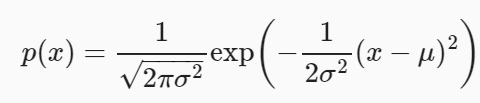

In [15]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

In [16]:
#INI MASIH ERROR
# Use numpy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

ImportError: ignored

<Figure size 324x180 with 1 Axes>

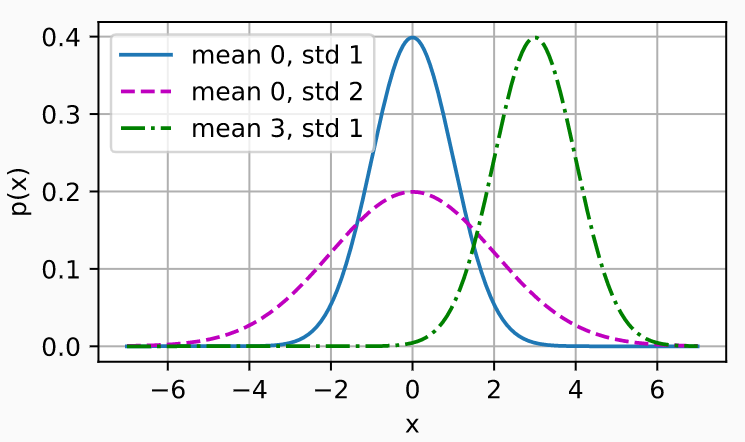

# 🌂Summary
Key ingredients in a machine learning model are training data, a loss function, an optimization algorithm, and quite obviously, the model itself.

Vectorizing makes everything better (mostly math) and faster (mostly code).

Minimizing an objective function and performing maximum likelihood estimation can mean the same thing.

Linear regression models are neural networks, too.

# **3.2 Linear Regression Implementation from Scratch**

In [17]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

# 🍠 3.2.1 Generating the Dataset

In [18]:
def synthetic_data(w, b, num_examples):  #save
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [19]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.1971, 1.0053]) 
label: tensor([1.1886])


In [20]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

ImportError: ignored

<Figure size 252x180 with 1 Axes>

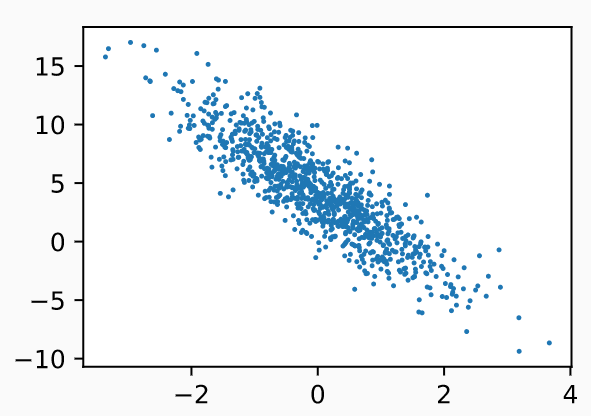

# 🧵 3.2.2. Reading the Dataset

In [21]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [22]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.2276,  1.4373],
        [ 0.0541, -0.3310],
        [ 1.8305, -1.4303],
        [ 0.5687, -0.0421],
        [ 1.5548,  0.9743],
        [-0.9325, -1.0996],
        [ 0.9293, -1.8667],
        [-0.2786, -1.5225],
        [ 0.9498, -0.9270],
        [-1.4853, -0.9482]]) 
 tensor([[-1.1567],
        [ 5.4359],
        [12.7274],
        [ 5.4713],
        [ 4.0031],
        [ 6.0777],
        [12.4086],
        [ 8.8114],
        [ 9.2549],
        [ 4.4473]])


# 🐫 3.2.3. Initializing Model Parameters

In [23]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# ⌚ 3.2.4. Defining the Model

In [24]:
def linreg(X, w, b):  #save
    """The linear regression model."""
    return torch.matmul(X, w) + b

# 😶 3.2.5. Defining the Loss Function

In [25]:
def squared_loss(y_hat, y):  #save
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

# 🍲 3.2.6. Defining the Optimization Algorithm

In [26]:
def sgd(params, lr, batch_size):  #save
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

# 🏃 3.2.7 Training

In [27]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.029437
epoch 2, loss 0.000101
epoch 3, loss 0.000048


# 🌆 3.2.8. Summary
We saw how a deep network can be implemented and optimized from scratch, using just tensors and auto differentiation, without any need for defining layers or fancy optimizers.

This section only scratches the surface of what is possible. In the following sections, we will describe additional models based on the concepts that we have just introduced and learn how to implement them more concisely.

# **3.3 Concise Implementation of Linear Regression**

# 🐲 3.3.1 Generating the Dataset

In [28]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

# 👀 Reading the Dataset

In [29]:
def load_array(data_arrays, batch_size, is_train=True):  #save
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [30]:
next(iter(data_iter))

[tensor([[ 0.8323, -0.1915],
         [ 0.9269,  0.3825],
         [ 0.7670,  2.0813],
         [-2.4654, -0.1296],
         [-1.9626, -0.5069],
         [ 0.1001, -0.7325],
         [-0.4467, -0.5433],
         [ 0.6499,  1.0186],
         [-1.4963,  0.9419],
         [-1.4824,  0.6350]]), tensor([[ 6.5263],
         [ 4.7373],
         [-1.3443],
         [-0.2853],
         [ 2.0192],
         [ 6.8871],
         [ 5.1587],
         [ 2.0255],
         [-2.0064],
         [-0.9350]])]

# 🌠 3.3.3. Defining the Model

In [31]:
# `nn` is an abbreviation for neural networks
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

# 💪 3.3.4. Initializing Model Parameters

In [32]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

# 💸 3.3.5. Defining Loss Funtion

In [33]:
loss = nn.MSELoss()

# 🙂 3.3.6. Defining the Optimization Algorithm

In [34]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

# 🚵 3.3.7. Training

In [35]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000292
epoch 2, loss 0.000104
epoch 3, loss 0.000105


In [36]:
w = net[0].weight.data
print('error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b:', true_b - b)

error in estimating w: tensor([-0.0002,  0.0007])
error in estimating b: tensor([-0.0005])


# 🚪3.3.8. Summary
Using PyTorch’s high-level APIs, we can implement models much more concisely.

In PyTorch, the data module provides tools for data processing, the nn module defines a large number of neural network layers and common loss functions.

We can initialize the parameters by replacing their values with methods ending with _.

# **3.5 The Image Classification Dataset**

In [45]:
#%matplotlib inline
!pip install matplotlib==3.0.2
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

     |████████████████████████████████| 12.9 MB 17.1 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotlib-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
d2l 0.17.3 requires matplotlib==3.3.3, but you have matplotlib 3.0.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# 🐏 3.5.1. Reading the Dataset


In [38]:
# `ToTensor` converts the image data from PIL type to 32-bit floating point
# tensors. It divides all numbers by 255 so that all pixel values are between
# 0 and 1
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

In [39]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [40]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [41]:
def get_fashion_mnist_labels(labels):  #save
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [42]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

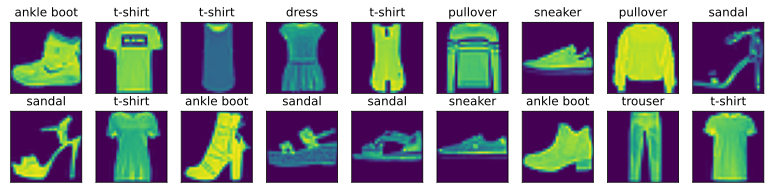

In [46]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

# 🧧 3.5.2. Reading a Minibatch

In [48]:
batch_size = 256

def get_dataloader_workers():  #save
    """Use 4 processes to read the data."""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [49]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


'5.16 sec'

# 📌 3.5.3. Putting All Things Together

In [51]:
def load_data_fashion_mnist(batch_size, resize=None):  #save
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [52]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


# 🌞 3.5.4. Summary
Fashion-MNIST is an apparel classification dataset consisting of images representing 10 categories. We will use this dataset in subsequent sections and chapters to evaluate various classification algorithms.

We store the shape of any image with height  h  width  w  pixels as  h×w  or ( h ,  w ).

Data iterators are a key component for efficient performance. Rely on well-implemented data iterators that exploit high-performance computing to avoid slowing down your training loop.